## Setting Up

### Import packages here

In [1]:
import numpy as np
from xarray import open_dataset
from pandas import to_datetime
from netCDF4 import Dataset
from wrf import getvar, ll_to_xy
import glob as gl
import matplotlib.pyplot as plt
from matplotlib import colorbar, colors, tri, patches
import cmocean
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
plt.rcParams.update({'font.size': 14})
K2C = -273.15

### Set the directories and get list of filenames

In [2]:
# directories
proj_dir = '../output/'

# filenames

# wrf file
wrf_grid_file = proj_dir + 'wrf_grid.nc'

fvcom_grid_file = proj_dir + 'fvcom_grid.nc' 

### Get metadata for WRF grid

In [3]:
# Add spatial coordinates
ncfile = Dataset(wrf_grid_file)
wrf_lon = getvar(ncfile,'lon')
wrf_lat = getvar(ncfile,'lat')
wrf_hgt = getvar(ncfile,'HGT')

### Get metadata for FVCOM grid

In [4]:
fvcom = open_dataset(fvcom_grid_file,decode_times=False, drop_variables=['siglay', 'siglev'])

### Plotting domain 

In [5]:
def cmap_enforce_pivot(cmapin,vmin,vmax,pivot=0,N=256):
    cmap_np = cmapin(np.linspace(0,1,N))
    below = cmap_np[0:int(np.ceil(N/2)),:]
    above = cmap_np[int(np.ceil(N/2))::,:]

    vrange = vmax-vmin
    below_N = round(abs(vmin)/vrange*N)
    above_N = round(abs(vmax)/vrange*N)

    newrgb = np.zeros((N, 4))
    for i in range(4):  # loop through each column of cmap
        below_interp = np.interp(np.linspace(vmin,pivot,below_N),np.linspace(vmin,pivot,below.shape[0]),below[:,i])
        above_interp = np.interp(np.linspace(pivot,vmax,above_N),np.linspace(pivot,vmax,above.shape[0]),above[:,i])
        newrgb[:,i] = np.append(below_interp,above_interp)

    return cmocean.tools.cmap(newrgb)

In [6]:
#chicago
center_x = -87.6033652926138
center_y = 41.893832881012315
zoom = [center_x-0.25, 
        center_x+0.25, 
        center_y-0.25,
        center_y+0.25]

/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


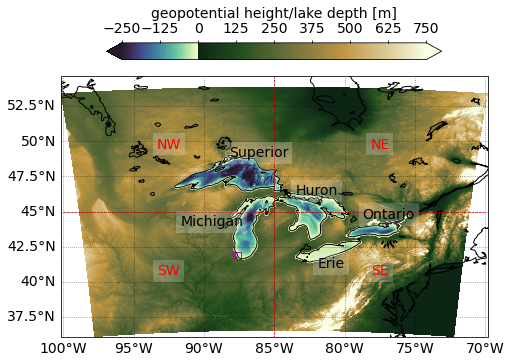

In [7]:
## WRF-GLST W10

# Create a figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=crs.PlateCarree())
ax.set_extent([wrf_lon.min(), 
               wrf_lon.max(), 
               wrf_lat.min(), 
               wrf_lat.max()])

# Download and add the states and coastlines
coast = cfeature.NaturalEarthFeature(
        category='physical',
        name='coastline',
        facecolor='none',
        scale='50m')
lakes = cfeature.NaturalEarthFeature(
        category='physical',
        name='lakes',
        facecolor='none',
        scale='50m')
ax.add_feature(lakes)
ax.add_feature(coast)

vmin = -250
vmax = 750
cmap = cmap_enforce_pivot(cmocean.cm.topo,vmin,vmax)

# Plot the results
plt.pcolormesh(wrf_lon, wrf_lat, wrf_hgt, 
             vmin=vmin, vmax=vmax,
             transform=crs.PlateCarree(),
             cmap=cmap)

plt.scatter(fvcom.lon,fvcom.lat,s=0.5,c=-fvcom.h,
            vmin=vmin, vmax=vmax,
            transform=crs.PlateCarree(),
            cmap=cmap)

ax.add_patch(patches.Rectangle(xy=(zoom[0],zoom[2]), width=0.5, height=0.5,
                                facecolor='none', edgecolor='m',
                                transform=crs.PlateCarree()))

lakes = ['Michigan','Huron','Erie','Superior','Ontario']
lakes_lon = [-87.2, -80.5, -80, -84, -75]
lakes_lat = [44, 46.2, 41, 48.9, 44.5]
for ll, lake in enumerate(lakes):
    t = plt.text(lakes_lon[ll],lakes_lat[ll],lake,horizontalalignment='right',color='black')
    t.set_bbox(dict(facecolor='white', alpha=0.2,linewidth=0))
    
plt.plot([-85,-85],[30,60],'r--',linewidth=0.7)
plt.plot([-100,-70],[45,45],'r--',linewidth=0.7)
    
areas = ['NW','NE','SW','SE']
areas_lon = [-92.5, -77.5, -92.5, -77.5]
areas_lat = [49.5, 49.5, 40.5, 40.5]
for aa, area in enumerate(areas):
    t = plt.text(areas_lon[aa],areas_lat[aa],area,horizontalalignment='center',color='red')
    t.set_bbox(dict(facecolor='white', alpha=0.2,linewidth=0))

# Add a color bar
cb = plt.colorbar(ax=ax, shrink=.5, label='geopotential height/lake depth [m]', 
                  extend='both',location='top')
cb.set_ticks(range(vmin,vmax+125,125))

# Add the gridlines
gl = ax.gridlines(color="black", linestyle="dotted", draw_labels=True, alpha=0.5)
gl.xlabels_top = None
gl.ylabels_right = None
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

#plt.title("WRF-GLST: Mean W10 (2018 JJA)")

#plt.show()

plt.savefig('../figures/wrf_fvcom_topobathy',dpi=600,bbox_inches='tight')

/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


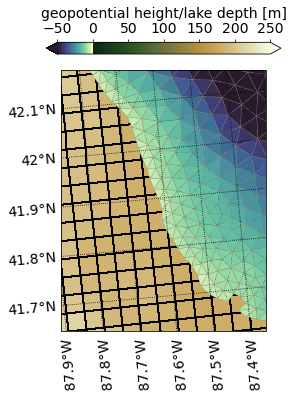

In [8]:
## WRF-GLST W10

# Create a figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=crs.LambertConformal())
ax.set_extent(zoom)

vmin = -50
vmax = 250
cmap = cmap_enforce_pivot(cmocean.cm.topo,vmin,vmax)

# Plot the results
plt.pcolormesh(wrf_lon, wrf_lat, wrf_hgt, 
             vmin=vmin, vmax=vmax,
             transform=crs.PlateCarree(),
             edgecolors='k',
             cmap=cmap)

triangles = tri.Triangulation(fvcom.lon,fvcom.lat,fvcom.nv.transpose()-1)
plt.tripcolor(triangles,-fvcom.h,
              edgecolors='gray',
              vmin=vmin, vmax=vmax,
              transform=crs.PlateCarree(),
              cmap=cmap)

# Add a color bar
cb = plt.colorbar(ax=ax, shrink=.35, label='geopotential height/lake depth [m]', 
                  extend='both',location='top')
cb.set_ticks(range(vmin,vmax+50,50))

# Add the gridlines
gl = ax.gridlines(color='black', linestyle="dotted", 
                  draw_labels=True, alpha=1, x_inline=False, y_inline=False)
gl.top_labels = None
gl.right_labels = None
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

#plt.title("WRF-GLST: Mean W10 (2018 JJA)")

#plt.show()

plt.savefig('../figures/wrf_fvcom_topobathy_zoomin',dpi=600,bbox_inches='tight')